In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
import requests
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

## GBIF data citations

#### Load

In [2]:
# Get citation data from GBIF API
r = requests.get(url="https://www.gbif.org/api/resource/search?contentType=literature&limit=700&gbifDatasetKey=7e380070-f762-11e1-a439-00145eb45e9a")
data = r.json()
df = pd.DataFrame(data['results'])

#### Clean

In [3]:
# Check nulls in useful fields
df[['month', 'day', 'year', 'peerReview', 'literatureType']].isna().sum()

# Filter out non-paper and non-peer-reviewed papers
df = df[(df['peerReview']) & (df['literatureType'] == 'journal')]

# Fill nulls: we don't care about the day so arbitrarily set to 1. Month set to median
median_month = int(df[['month']].median())
df.fillna(value={'day' : 1.0, 'month' : median_month}, inplace=True)

# Map numeric months to month names + add nominal date field
# df['monthname'] = df['month'].map(month_names)
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df['monthname'] = df['date'].dt.month_name()
df.head(2)

,title,authors,year,source,identifiers,keywords,websites,month,publisher,day,...,issue,editors,sourceType,city,institution,department,code,genre,date,monthname
0,A new species of Cypris (Crustacea: Ostracoda)...,"[{'firstName': 'FRANCESC', 'lastName': 'MESQUI...",2020,Zootaxa,{'doi': '10.11646/zootaxa.4759.1.8'},"[Crustacea, Cypris, Ostracoda, distribution, i...",[https://doi.org/10.11646/zootaxa.4759.1.8],4.0,Magnolia Press,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-01,April
1,How reliable are species identifications in bi...,"[{'firstName': 'Tiago M. S.', 'lastName': 'Fre...",2020,Systematics and Biodiversity,{'doi': '10.1080/14772000.2020.1730473'},"[Auchenipteridae fishes, GBIF, Link, Linnean s...",[https://doi.org/10.1080/14772000.2020.1730473],4.0,Informa UK Limited,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-03,April


#### Aggregation

In [4]:
# Counts per monthyear
monthly_aggs = df.groupby(['year', 'month', 'monthname'])
monthly_count = monthly_aggs.size()

# Convert to dataframe
monthly_df = pd.DataFrame(monthly_count, columns=['paper_count'])
monthly_df.head()

paper_count
year month monthname             
2015 1.0   January              1
2016 3.0   March                1
     6.0   June                 2
     7.0   July                 3
     8.0   August               1

#### Create date index
Build a complete, month-level date index for the period between first paper published and the current month. 
Goal is to identify and fill months where 0 papers were published.

In [5]:
import datetime

# Create a full monthyear index for active period, dates set to monthly intervals
all_months = pd.date_range(start="01-01-2015", end=datetime.date.today(), freq='MS')
df_date = pd.DataFrame(all_months, columns=['start_of_month'])

# Split the dates
df_date['year'] = df_date['start_of_month'].dt.year
df_date['month'] = df_date['start_of_month'].dt.month
df_date['monthname'] = df_date['start_of_month'].dt.month_name()

df_date = df_date[['year', 'month', 'monthname']]
df_date.head(2)

,year,month,monthname
0,2015,1,January
1,2015,2,February


#### Join date spine to GBIF data

In [6]:
# create multi-level index in the same shape as the gbif data (there must be an easier way than this, can you do during timeindex creation?)
mi = pd.MultiIndex.from_frame(df_date)

# Left join index to monthly paper counts
gbif_paper_history = pd.concat([pd.Series(index=mi, dtype='datetime64[ns]'), monthly_df], axis=1)['paper_count']

# fill null counts with 0
null_paper_bool = gbif_paper_history.isnull()
gbif_paper_history.loc[null_paper_bool] = 0.0
gbif_paper_history.head()

year  month  monthname
2015  1      January      1.0
      2      February     0.0
      3      March        0.0
      4      April        0.0
      5      May          0.0
Name: paper_count, dtype: float64

## Portal record counts

#### Load

In [7]:
# Retrieve the count of GBIF-eligible records from the DP
r = requests.get(url="https://data.nhm.ac.uk/api/3/action/datastore_get_resource_versions?resource_id=05ff2255-c38a-40c9-b657-4ccb55ab2feb&filters=%7B%22_exclude_mineralogy%22:true%7D")
dp = r.json()
dp.keys()

dict_keys(['help', 'success', 'result'])

#### Clean

In [8]:
# Isolate the result list and translate the timestamp
dp_df = pd.DataFrame(dp['result'])
dp_df.rename(columns={'count' : 'record_count'}, inplace=True)
dp_df['date'] = pd.to_datetime(dp_df['version'], unit='ms', origin='unix')

# Split out date parts to make monthyear matching easier
dp_df['month'] = dp_df['date'].dt.month
dp_df['year'] = dp_df['date'].dt.year
dp_df['monthname'] = dp_df['date'].dt.month_name()

dp_df.head(3)

,record_count,version,changes,date,month,year,monthname
0,3150297,1504051200000,3150297,2017-08-30,8,2017,August
1,3150100,1504396800000,183706,2017-09-03,9,2017,September
2,3150192,1504656000000,335,2017-09-06,9,2017,September


#### Aggregations

In [9]:
# Group by month and year columns. Aggregation = max per month
dp_monthly_aggs = dp_df.groupby(['year', 'month', 'monthname'])[['year', 'month', 'monthname', 'record_count']]
monthly_max = dp_monthly_aggs.max()
monthly_max.head()

year  month  monthname  record_count
year month monthname                                      
2017 8     August     2017      8     August       3150297
     9     September  2017      9  September       3154163
     10    October    2017     10    October       3416817
     11    November   2017     11   November       3437828
     12    December   2017     12   December       3439755

### Join GBIF and Portal data

In [10]:
# Get rid of months without record_count data
final_result = pd.concat([gbif_paper_history, monthly_max], sort=False, axis=1).dropna()
final_result = final_result[['paper_count', 'record_count']]
final_result.head(5)

paper_count  record_count
year month monthname                           
2017 8     August             0.0     3150297.0
     9     September          2.0     3154163.0
     10    October            2.0     3416817.0
     11    November           4.0     3437828.0
     12    December           8.0     3439755.0

### Plot data

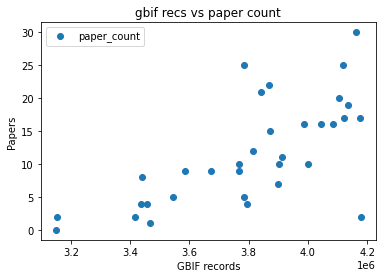

In [11]:
# Eyeball count of GBIF records against papers published
final_result.plot(x='record_count', y='paper_count', style='o')  
plt.title('gbif recs vs paper count')  
plt.xlabel('GBIF records') 
plt.ylabel('Papers')  
plt.show()

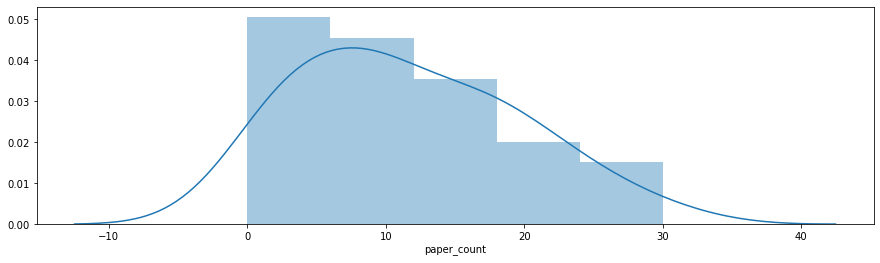

In [12]:
# Show distribution of monthly citation counts
plt.figure(figsize=(15,4))
plt.tight_layout()
seabornInstance.distplot(final_result['paper_count'])

### Regression

In [13]:
# Goal: predict X using values of Y
X = final_result['record_count'].values.reshape(-1,1)
y = final_result['paper_count'].values.reshape(-1,1)

In [14]:
# Split into test + training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
regressor = LinearRegression()  
regressor.fit(X_train, y_train) # train the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
# Retrieve the intercept:
print(regressor.intercept_)

# Retrieve the slope:
print(regressor.coef_)

[-44.09595176]
[[1.44283223e-05]]


In [16]:
y_pred = regressor.predict(X_test)

In [17]:
# compare predicted with actual values
comparison = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
comparison

,Actual,Predicted
0,9.0,10.262695
1,1.0,5.944457
2,5.0,7.041153
3,17.0,15.393406
4,7.0,12.186726
5,2.0,5.202985
6,16.0,13.431630
7,4.0,5.506139
8,22.0,11.715670
9,19.0,15.592503


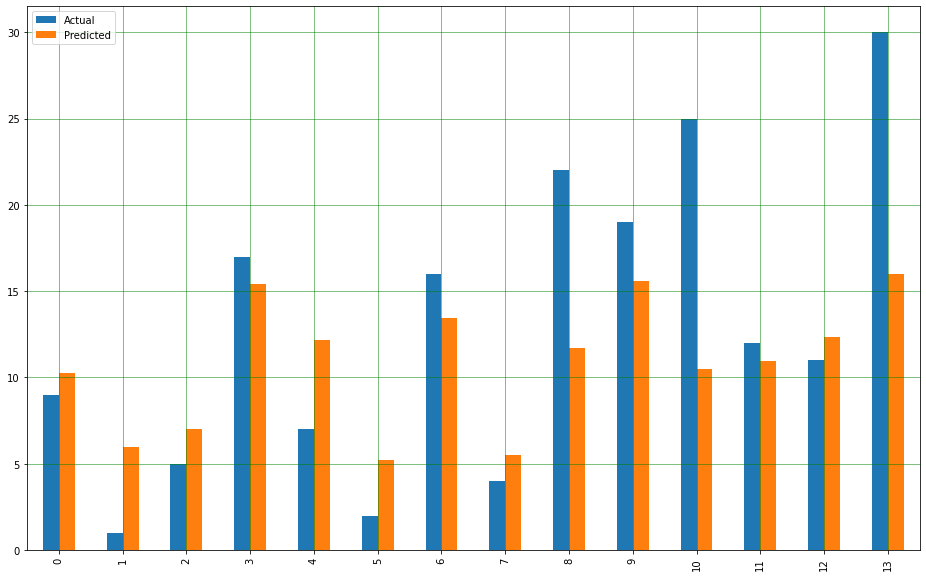

In [18]:
comparison.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

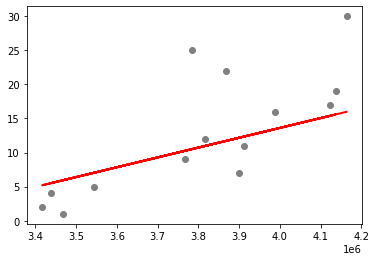

In [19]:
# prediction vs test data
plt.scatter(X_test, y_test, color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

In [20]:
# Evaluation:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 4.780853449192798
Mean Squared Error: 43.258825763302085
Root Mean Squared Error: 6.577144195112502
